<a href="https://colab.research.google.com/github/kristofvl/Activate2/blob/main/Steps_and_Walking_Detection_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Steps and Walking Activity Detection from Bangle and GT3X data**

## **Part 1 : Module And Repository Import**

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

Cloning the repository at https://github.com/kristofvl/Activate2

In [ ]:
!git clone https://github.com/kristofvl/Activate2

Cloning into 'Activate2'...
remote: Enumerating objects: 599, done.
remote: Counting objects: 100% (218/218), done.
remote: Compressing objects: 100% (192/192), done.
remote: Total 599 (delta 24), reused 218 (delta 24), pack-reused 381
Receiving objects: 100% (599/599), 677.10 MiB | 15.67 MiB/s, done.
Resolving deltas: 100% (212/212), done.
Checking out files: 100% (433/433), done.


In [ ]:
path = "/content/Activate2/"

To change the subject, change the id.

**Given Subjects**:

Put any ID from 001 to 033. 
Number of Participants: 27, Number of days recorded: 33

In [ ]:
id = '006'

## **Part 2: Class and Functions Declaration**



1.   Read : Reads all CSV Data
2.   Step : Detects steps in Dataframe using parameters consecutive steps, interval and threshold
3.   walk_detect : Detects walking segments using the Dataframe obtained from step detector algorithm using adjustable windowsize and threshold steps.
4.   plot : Reads and plots accelerometer data, steps, walking segments
5.   cleanBangleCSV : Remove extra headers in Bangle CSV Files
6.   parse : Brute Force Search for the best parameters 

In [ ]:
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt

# Activate class that hold all data and algorithms for our experiment:
class Act:
    #path = os.path.expanduser('~')+"/Activate2/"  # path to data files
    path = "/content/Activate2/"
    # List of participants and day-long recordings:
    ids = [str(item).zfill(3) for item in range(1,34)] # 27 persons, 33 days
    
    # allow constructor to specify path
    def __init__(self, path):
        self.path = path

    # read all CSV data for one participant
    def read(self, name):
        '''
        Reads the CSV data and cleans the dataframe for the given participant
        
        Parameters:
        
        name (ID of the participant)
        Returns:
        Cleaned Dataframes for Actigraph, Bangle and GT3X
        '''
        # read Bangle data:
        d1 = pd.read_csv(self.path + "_CSV/" +  name + '_Bangle.csv', names=['time', 'acc_x', 'acc_y', 'acc_z', 'g'], sep="\s+|;|,",
                         engine='python')
        del d1["g"]
        # read GT3X data:
        d2 = pd.read_csv(self.path + "_CSV/" + name + '_GT3X.csv', names=['time', 'acc_x', 'acc_y', 'acc_z'], header=10)
        # read ActiLife output:
        try:
            # d11 = pd.read_csv(name + '_steps.csv', names=['time', 's1', 's2'], header=1)
            d11 = pd.read_csv(self.path + "_CSV/" +  name + '_steps_GT3X.csv', names=['time', 's'], header=1)
        except:
            d11 = []
        # convert timestamps:
        d1["time"] = [dt.datetime.strptime(d1_t, "%H:%M:%S.%f") for d1_t in d1["time"]]
        if name[-3:] == '032':
            d2["time"] = [dt.datetime.strptime(d2_t, "%m/%d/%Y %H:%M:%S.%f") for d2_t in
                          d2["time"]]  # 032 has other format
        else:
            d2["time"] = [dt.datetime.strptime(d2_t, "%d-%b-%y %H:%M:%S.%f") for d2_t in d2["time"]]
        d1["time"] = [d1_t.replace(month=d2["time"][0].month, year=d2["time"][0].year, day=d2["time"][0].day) for d1_t
                      in
                      d1["time"]]
        if len(d11) > 0:
            d11["time"] = [dt.datetime.strptime(d11_t, "%H:%M:%S") for d11_t in d11["time"]]
            d11["time"] = [d11_t.replace(month=d2["time"][0].month, year=d2["time"][0].year, day=d2["time"][0].day) for
                           d11_t in d11["time"]]
        # obtain first and last timestamps of Bangle raw data:
        t1 = d1["time"].iloc[0]
        t2 = d1["time"].iloc[-1]
        # cut off anythong before and after these timestamps in the ActiGraph data:
        d2 = d2[t1 <= d2["time"]]
        d2 = d2[d2["time"] <= t2]
        d2 = d2.reset_index(drop=True)  # make sure index starts at 0
        d11 = d11[t1 <= d11["time"]]
        d11 = d11[d11["time"] <= t2]
        d11 = d11.reset_index(drop=True)  # make sure index starts at 0
        # return dataframes:
        return d1, d2, d11

    # Activate's step detector, using dataframe d, and parameters (consec, intv, th)
    def step(self, d, consec=6, intv=80, th=0.6):
        '''
        Step Detection using the cleaned Dataframe
        
        Parameters:
        
        d : Dataframe in which steps are to be detected
        consec : Consecutive Steps as threshold value for step detection
        intv: Sampling of the dataframe
        th: Threshold value for step detection using accelerometer values
        
        Returns: 
        
        DataFrame with column "s" denoting occurence of a step
        
        '''
        consecSteps = 0
        stepsInt = 0
        stepTimeDiff = 0
        mag = ((d["acc_x"] ** 2 + d["acc_y"] ** 2 + d["acc_z"] ** 2) ** .5) / 2  # get magnitudes
        for i in range(1, len(mag) - 1, 1):  # get peaks as candidate steps
            if (mag[i] > th) and (mag[i] > mag[i - 1]) and (mag[i] > mag[i + 1]):
                mag[i] = 10
        for i in range(1, len(mag) - 1, 1):  # track time distances
            stepsInt += 80
            if (mag[i] == 10):
                stepTimeDiff = stepsInt
                stepsInt = 0
                if (stepTimeDiff >= 1100) or (stepTimeDiff <= 240):  # milliseconds
                    consecSteps = 0
                else:
                    consecSteps = consecSteps + 1
                    if (consecSteps >= consec):
                        if (consecSteps == consec):
                            steps = consec
                            j = 0
                            while steps > 0:  # mark all <consec> previous as steps
                                if (mag[i - j] == 10):
                                    mag[i] = 100  # step!
                                    steps = steps - 1
                                j = j + 1
                        else:
                            mag[i] = 100  # step!
        d["s"] = [m == 100 for m in mag]
        return d

    ## Detect walking segments from a dataset, using the above step detector, and
    ## return a pandas dataframe with the following columns:
    ##    - start and stop timestamps of the walking segment (datetime)
    ##    - the number of steps of the walking segment
    ##    - the average amplitude of the peak that caused the steps
    def walk_detect(self, d, windowSize, threshold):
        """
        Walking Segment Detection using Step Detector
        
        Parameters: 

        d: Dataframe with step detector algorithm
        windowSize: window size for iteration 
        threshold:number of steps in the window
        
        Returns: 
        
        Dataframe with following columns:
        - start and stop timestamps of the walking segment (datetime)
        - the number of steps of the walking segment
        - the average amplitude of the peak that caused the steps
        
        """
        def slidingWindow(sequence, winSize, step=1):
          """
          
          Parameters: 
          
          sequence: Dataset for which sliding window is generated
          winSize: window size for iteration
          step: number of steps window should traverse
          
          Returns: 
          
          A Generator iterates through
          the defined chunks of input sequence.
          
          """
          # Verify the inputs
          try: 
              it = iter(sequence)
          except TypeError:
              raise Exception("**ERROR** sequence must be iterable.")
          if not ((type(winSize) == type(0)) and (type(step) == type(0))):
              raise Exception("**ERROR** type(winSize) and type(step) must be int.")
          if step > winSize:
              raise Exception("**ERROR** step must not be larger than winSize.")
          if winSize > len(sequence):
              raise Exception("**ERROR** winSize must not be larger than sequence length.")
    
          # Pre-compute number of chunks to emit
          numOfChunks = int((len(sequence)-winSize)/step)+1
          
          # yield the iterable
          for i in range(0,numOfChunks*step,step):
              yield i, sequence[i:i+winSize]
        
        start_time= []
        stop_time = []
        steps_count = []
        mag = [] 
        ws = [0] * len(d)


        for i, window in slidingWindow(d, windowSize, 1):
            window.s = window.s * 1
            if window.s.sum() > threshold:
                ws[i] = 1
                mag_temp = []
                # add start time
                start_time.append(window["time"].iloc[0]) 
                # add stop time
                stop_time.append(window["time"].iloc[windowSize - 1]) 
                # add steps count
                steps_count.append(window["s"].sum()) 
                # add magnitude
                for j in range(0, windowSize - 1): 
                    # get magnitudes
                    mag_temp.append(((window["acc_x"].iloc[j] ** 2 + window["acc_y"].iloc[j] ** 2 + window["acc_z"].iloc[j] ** 2) ** .5) / 2) 
                mag.append(sum(mag_temp) / len(mag_temp)) 
            else:
              ws[i] = 0

        d["ws"] = ws

        # Zip and Return DataFrame consisting of start time, stop time, steps count and average amplitude       
        df_main = pd.DataFrame(list(zip(start_time, stop_time, steps_count, mag)), columns = ["start", "stop", "steps_count", "average amplitude"])

        return df_main


    # read and plot the data for one participant
    def plot(self, d1, d2, d11=[]):
        '''
        Reads the data for one for one participant
        
        Parameters: Dataframes wiht Step and Walking Detection Algorithms for Actigraph, Bangle and GT3X
        
        Returns:
        
        Plot of the following:
        - Accelerometer Magnitudes for Bangle Data
        - Accelerometer Magnitudes for GT3X Data
        - Steps for Actigraph, Bangle and GT3X Data
        - Walking Segments for Bangle and GT3X Data
        - Steps per minute for Actigraph and Bangle
        
        '''
        # plot:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(sharex=True, nrows=4, figsize=(27, 4))
        ax1.plot(d1["time"], d1[["acc_x", "acc_y", "acc_z"]], lw=0.2)
        ax1.set_xlim(d1["time"][0], d1["time"][len(d1) - 1])
        ax1.set_ylim(-2, 2)
        ax1.set_yticks([-2, 0, 2])
        ax1.set_yticklabels([-2, 0, 2])
        ax1.set_ylabel('Bangle')
        ax2.plot(d2["time"], d2[["acc_x", "acc_y", "acc_z"]], lw=0.2)
        ax2.set_ylim(-2, 2)
        ax2.set_yticks([-2, 0, 2])
        ax2.set_yticklabels([-2, 0, 2])
        ax2.set_ylabel('GT3X')
        if len(d11) > 0:
            ax3.plot(d11["time"], d11["s"] > 0, 'm', lw=0.1)
        if 's' in d1.columns:
            ax3.plot(d1["time"], d1["s"] - 1, 'r', lw=0.1)
        if 's' in d2.columns:
            ax3.plot(d2["time"], d2["s"] - 2, 'k', lw=0.1)
        ax3.plot(d1["time"], d1["ws"] - 3 , 'r', drawstyle = 'steps-mid', lw = 0.2)
        ax3.plot(d2["time"], d2["ws"] - 4 , 'k', drawstyle = 'steps-mid', lw = 0.2)
        ax3.set_ylabel('Steps')
        ax3.set_ylim(-4, 1)
        ax3.set_yticks([-3.5, -2.5 ,-1.5, -0.5, 0.5])
        ax3.set_yticklabels(['W_G', 'W_B', 'G', 'B', 'A'])
        ax4.set_ylabel('Steps/min')
        ax4.set_ylim(0, 240)
        ax4.set_yticks([0, 120])
        ax4.set_yticklabels(['B', 'A'])
        plt.tight_layout()
        plt.subplots_adjust(hspace=0, wspace=0)
        return plt

    # take a Bangle csv file and remove the headers
    def cleanBangleCSV(self, name):
        os.system("sed -i '' '/^t/d' " + name + "_Bangle.csv")  # remove headers (that start with t)

    def parse(self, read_from_csv=True, write_to_pickle=True, write_to_fig=True, param_search=False, walking_detect = True):
        '''
        Helper function that does a brute-force search for a best parameters
        
        Returns:
        
        best threshold _th, best consecutive steps _consecs, number of found _steps
        and Dataframe consisting of walking segments for the participants
        
        '''
        # helper function that does a brute-force search for a best parameters,
        # returns best threshold _th, best consecutive steps _consecs, and number of found _steps:
        def find_step_p(d, consec, intv, target_steps):
            _th = _best_th = 0.65
            jump = 0.01
            _steps = _minsteps = 0
            _consecs = _best_consecs = 6
            prev_diff = len(d)  # something ridiculously high
            while _th > 0.49:
                _consecs = 6
                while _consecs > 0:
                    _steps = sum(self.step(d, _consecs, intv, th=_th)["s"])
                    if abs(target_steps - _steps) < abs(target_steps - _minsteps):
                        _best_th = _th
                        _minsteps = _steps
                        _best_consecs = _consecs
                    _consecs = _consecs - 1
                _th = _th - jump
            return _best_th, _best_consecs, _minsteps
        # the main experiment routine starts here:
        ret = []
        for id in self.ids:
            if read_from_csv:
                print("Reading data from " + self.path + "_CSV/" + id)
                d1, d2, d11 = self.read(id)
                print("  - time span:", d1["time"].iloc[0], "-", d1["time"].iloc[-1], " = ",
                      (d1["time"].iloc[-1]-d1["time"].iloc[0]).total_seconds() / 3600, "hrs.")
            else:
                print("Reading data from " + self.path + "_Pkl/" + id)
                d1 = pd.read_pickle(self.path + "_Pkl/" + id + '_Bangle.pkl')
                d2 = pd.read_pickle(self.path + "_Pkl/" + id + '_GT3X.pkl')
                d11 = pd.read_pickle(self.path + "_Pkl/" + id + '_steps_GT3X.pkl')
            ## calculate steps parameters:
            target_steps = sum(d11["s"])
            if param_search:
                bangle_th, bangle_c, bangle_steps = find_step_p(d1, 6, 80, target_steps)
                gt3x_th, gt3x_c, gt3x_steps = find_step_p(d2, 1, 33, target_steps)
                d1 = self.step(d1, bangle_c, 80, bangle_th)
                d2 = self.step(d2, gt3x_c, 33, gt3x_th)
            else:
                bangle_c, bangle_th = [4, 0.54]
                d1 = self.step(d1, bangle_c, 80, bangle_th)
                bangle_steps = sum(d1["s"])
                gt3x_c, gt3x_th = [4, 0.54]
                d2 = self.step(d2, gt3x_c, 33, gt3x_th)
                gt3x_steps = sum(d2["s"])

            print("  - calculated steps: (Bangle:", bangle_steps,
                  ", GT3X:", gt3x_steps, ", ActiLife:", target_steps, ")")
            ## sum all steps per minute bin:
            d1_agg = d1.resample('Min', on='time')["s"].sum()
            d2_agg = d2.resample('Min', on='time')["s"].sum()
            d11_agg = d11.resample('Min', on='time')["s"].sum()
            bangle_corr = d11_agg.corr(d1_agg, method='pearson')
            gt3x_corr   = d11_agg.corr(d2_agg, method='pearson')
            ## write pickle files:
            if write_to_pickle:
                d1.to_pickle(self.path + "_Pkl/" + id + '_Bangle.pkl')
                d2.to_pickle(self.path + "_Pkl/" + id + '_GT3X.pkl')
                d11.to_pickle(self.path + "_Pkl/" + id + '_steps_GT3X.pkl')
                d1_agg.to_pickle(self.path + "_Pkl/" + id + '_Bangle_steps1m.pkl')
                d2_agg.to_pickle(self.path + "_Pkl/" + id + '_GT3X_steps1m.pkl')
                d11_agg.to_pickle(self.path + "_Pkl/" + id + '_steps_GT3X_1m.pkl')
                print("  - written to pickle format")
            ## detect walking segments:
            if walking_detect:
                d1_walking  = self.walk_detect(d1, windowSize = 1500, threshold = 99)
                d2_walking = self.walk_detect(d2, windowSize = 3636, threshold = 99)
            ## plot and add histograms:
            f = self.plot(d1, d2, d11)  # use participant code
            f.gca().plot(d1_agg.index, 120*(d1_agg/max(d1_agg)), 'r')
            f.gca().fill_between(d1_agg.index, 120*(d1_agg/max(d1_agg)), color='r')
            f.gca().plot(d11_agg.index, 120*(d11_agg/max(d11_agg))+120, 'm')
            f.gca().fill_between(d11_agg.index, 120*(d11_agg/max(d11_agg)) + 120, 120, color='m')
            if write_to_fig:
                if not os.path.exists('_Fig'):
                    os.makedirs('_Fig')
                f.savefig(self.path + "_Fig/" + id + '.png')
                print("  - written to png figure")
            f.close()
            ret.append([id, d1["time"].iloc[0], d1["time"].iloc[-1],
                         (d1["time"].iloc[-1] - d1["time"].iloc[0]).total_seconds() / 3600,
                        target_steps, bangle_steps, bangle_th, bangle_c,
                        gt3x_steps, gt3x_th, gt3x_c, bangle_corr, gt3x_corr])
            ## save walking segments as per id
            d1_walking.to_csv(self.path + "/_Pkl/" + id + '_Bangle_walking_segments.csv')
            d2_walking.to_csv(self.path + "/_Pkl/" + id + '_GT3X_walking_segments.csv')
        return ret, d1_walking, d2_walking

In [ ]:
Act = Act(path)

## **Part 3: Data Exploration and Analysis**




1.   Reading Data from CSV Files
2.   Step Detection
3.   Walking Segment detection 
4.   Resampling and Correlation calculation


In [ ]:
d1, d2, d11 = Act.read(id)

Detect Steps and add these as an extra column "s" to the Dataframes:

In [ ]:
d1_step = Act.step(d1, consec=2, intv=80, th=0.62)
d2_step = Act.step(d2, consec=1, intv=33, th=0.56)

Walking function detects whether a given number of steps (threshold) were performed in a given timeframe (Sliding Window) and returns a DataFrame containing the start time, stop time, number of steps in the walking segment and the average accelerometer amplitude over the walking segment.

Detects Walking and adds an extra column "ws" to the dataframes, which denotes whether in a given timestamp walking activity was performed.


For time period of 120 Seconds, where 100 steps are considered as walking.


1. Bangle (with intv = 80), windowSize = 1500 (120*1000 msec / 80), threshold = 99 
2. GT3X (with intv = 33), windowSize = 2000 (120*1000 msec / 33), threshold = 99




In [ ]:
df_walking_bangle = Act.walk_detect(d1, windowSize = 1500, threshold = 99)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
df_walking_gt3x = Act.walk_detect(d2, windowSize = 3636, threshold = 99)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Resampling the steps data to plot steps per minute

In [ ]:
d1_agg = d1.resample('Min', on='time')["s"].sum()
d2_agg = d2.resample('Min', on='time')["s"].sum()
d11_agg = d11.resample('Min', on='time')["s"].sum()

Calculating the correlation between ActiLife calculated steps and Bangle and GT3X steps

In [ ]:
print("Pearson correlation between ActiLife and Bangle steps: " + str(d1_agg.corr(d11_agg, method='pearson')))
print("Pearson correlation between ActiLife and GT3X steps:   " + str(d2_agg.corr(d11_agg, method='pearson')))

Pearson correlation between ActiLife and Bangle steps: 0.9593798245440027
Pearson correlation between ActiLife and GT3X steps:   0.9666675040871638


## **Part 4: Data Visualization**

The following are visualized in the form of a plot:
1. Accelerometer Magnitudes for Bangle Data
2. Accelerometer Magnitudes for GT3X Data
3. Steps for Actigraph, Bangle and GT3X Data
4. Walking Segments for Bangle and GT3X Data
5. Steps per minute for Actigraph and Bangle


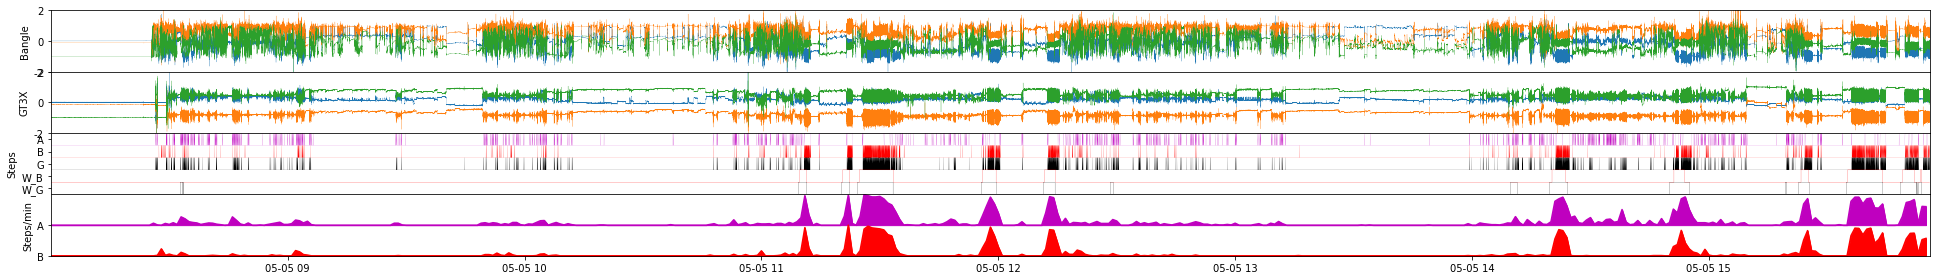

In [ ]:
f = Act.plot(d1, d2, d11)
f.gca().plot(d1_agg.index, 120*(d1_agg/max(d1_agg)), 'r')
f.gca().fill_between(d1_agg.index, 120*(d1_agg/max(d1_agg)), color='r')
f.gca().plot(d11_agg.index, 120*(d11_agg/max(d11_agg))+120, 'm')
f.gca().fill_between(d11_agg.index, 120*(d11_agg/max(d11_agg)) + 120, 120, color='m')
f.show()